In [15]:
# prerequisites
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

from scipy.stats import norm

import numpy as np
import os
import matplotlib.pyplot as plt

In [22]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 100, 100
n_hidden, z_dim = 256, 16

(60000, 784) (10000, 784)


In [23]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

In [24]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

In [25]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [26]:
# loss
reconstruction_loss = binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 256)          200960      input_4[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          32896       dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           2064        dense_8[0][0]                    
____________________________________________________________________________________________

In [27]:
# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Epoch 1/100
600/600 [==============================] - 4s 7ms/step - loss: 196.6140 - val_loss: 131.7553
Epoch 2/100
600/600 [==============================] - 4s 6ms/step - loss: 127.3074 - val_loss: 114.2640
Epoch 3/100
600/600 [==============================] - 4s 7ms/step - loss: 114.2154 - val_loss: 106.8602
Epoch 4/100
600/600 [==============================] - 4s 7ms/step - loss: 107.7976 - val_loss: 104.4058
Epoch 5/100
600/600 [==============================] - 4s 7ms/step - loss: 103.9878 - val_loss: 100.2052
Epoch 6/100
600/600 [==============================] - 4s 7ms/step - loss: 101.7007 - val_loss: 100.7928
Epoch 7/100
600/600 [==============================] - 4s 7ms/step - loss: 99.7964 - val_loss: 98.7292
Epoch 8/100
600/600 [==============================] - 4s 7ms/step - loss: 98.4819 - val_loss: 97.0812
Epoch 9/100
600/600 [==============================] - 4s 7ms/step - loss: 97.3560 - val_loss: 96.7282
Epoch 10/100
600/600 [==============================] - 4s 7m

In [28]:
# build encoder
encoder = Model(x, mu)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2064      
Total params: 235,920
Trainable params: 235,920
Non-trainable params: 0
_________________________________________________________________


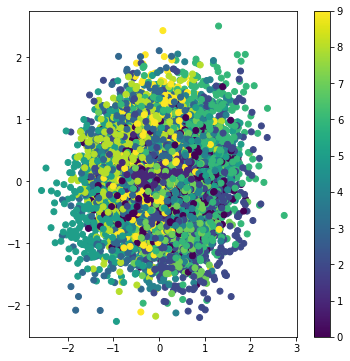

In [29]:
# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In [30]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_11 (Dense)             multiple                  2176      
_________________________________________________________________
dense_12 (Dense)             multiple                  33024     
_________________________________________________________________
dense_13 (Dense)             multiple                  201488    
Total params: 236,688
Trainable params: 236,688
Non-trainable params: 0
_________________________________________________________________


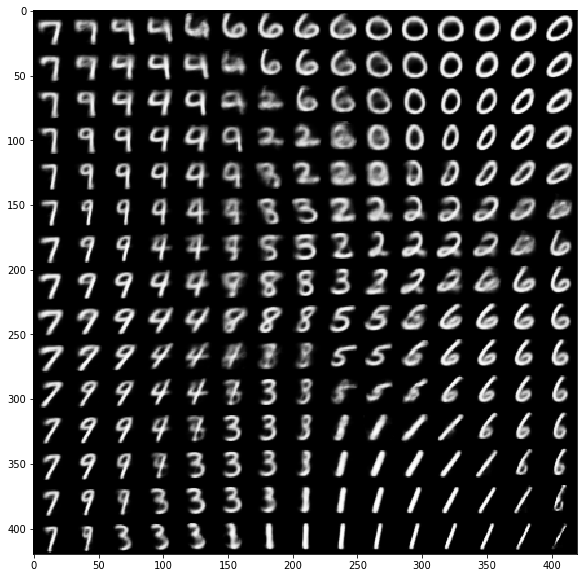

In [21]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()